The Dirty Cafe Sales dataset contains 10,000 rows across 8 columns of synthetic data representing sales transactions in a cafe. This dataset is intentionally "dirty," with missing values, inconsistent data, and errors introduced to provide a realistic scenario for data cleaning and exploratory data analysis (EDA). It can be used to practice cleaning techniques, data wrangling, and feature engineering.

We aim to handle all missing values and detect outliers to ensure the data is clean and suitable for model training.

# Import Important Libraries

In [1]:
# Standard and Data Handling
import numpy as np
import pandas as pd
from datetime import datetime
import re

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='white')
np.random.seed(0)

# Preprocessing
from sklearn.preprocessing import (
    StandardScaler, 
    MinMaxScaler, 
    LabelEncoder, 
    OneHotEncoder
)
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Model Selection and Evaluation
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV
)
from sklearn.metrics import (
    mean_absolute_error, 
    mean_squared_error, 
    r2_score
)

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import (
    RandomForestRegressor, 
    GradientBoostingRegressor
)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

In [2]:
# Loading the dataset
df = pd.read_csv('/kaggle/input/cafe-sales-dirty-data-for-cleaning-training/dirty_cafe_sales.csv')
df.head()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,ERROR,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11


In [3]:
# Check the data types of the column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    10000 non-null  object
 1   Item              9667 non-null   object
 2   Quantity          9862 non-null   object
 3   Price Per Unit    9821 non-null   object
 4   Total Spent       9827 non-null   object
 5   Payment Method    7421 non-null   object
 6   Location          6735 non-null   object
 7   Transaction Date  9841 non-null   object
dtypes: object(8)
memory usage: 625.1+ KB


In [4]:
# Set display for better viewing
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Initial Inspection
print("Dataset Shape", df.shape)


Dataset Shape (10000, 8)


In [5]:
print("First 5 Rows:")
display(df.head())

First 5 Rows:


,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,ERROR,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11


In [6]:
print("Data Types and Missing Values:")
display(df.info())

Data Types and Missing Values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    10000 non-null  object
 1   Item              9667 non-null   object
 2   Quantity          9862 non-null   object
 3   Price Per Unit    9821 non-null   object
 4   Total Spent       9827 non-null   object
 5   Payment Method    7421 non-null   object
 6   Location          6735 non-null   object
 7   Transaction Date  9841 non-null   object
dtypes: object(8)
memory usage: 625.1+ KB


None

In [7]:
print("Summary Statistics:")
df.describe()

Summary Statistics:


,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
count,10000,9667,9862,9821,9827,7421,6735,9841
unique,10000,10,7,8,19,5,4,367
top,TXN_1961373,Juice,5,3.0,6.0,Digital Wallet,Takeaway,UNKNOWN
freq,1,1171,2013,2429,979,2291,3022,159


# Handling Missing Values

In [8]:
# Calculate missing values percentage
missing_percent = df.isnull().mean() * 100
print("Missing Values Percentage:")
display(missing_percent.sort_values(ascending=False))

Missing Values Percentage:


Location           32.65
Payment Method     25.79
Item                3.33
Price Per Unit      1.79
Total Spent         1.73
Transaction Date    1.59
Quantity            1.38
Transaction ID      0.00
dtype: float64

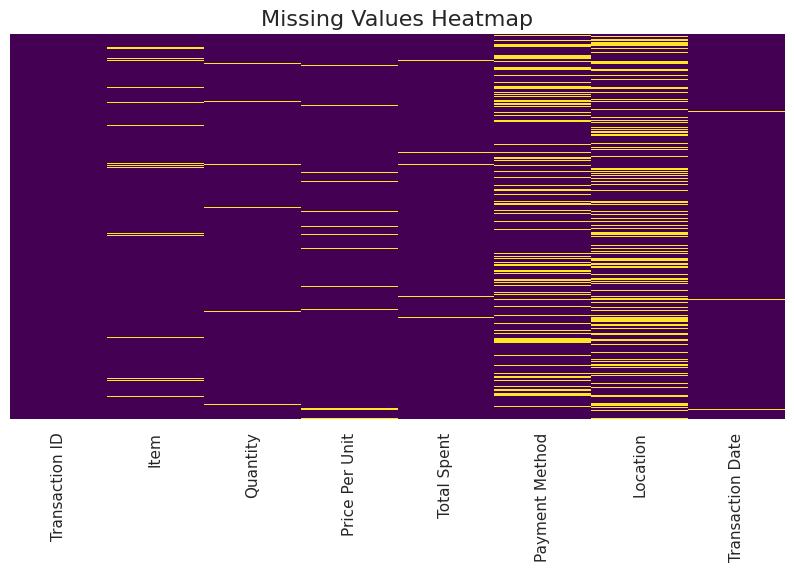

In [9]:
# Create a function to visualize missing values
def plot_missing_values(df):
    plt.figure(figsize=(10, 5))
    sns.heatmap(df.isnull(), cbar=False, cmap = 'viridis', yticklabels=False)
    plt.title("Missing Values Heatmap", fontsize=16)
    plt.show()
plot_missing_values(df)

In [10]:
# Handle missing values for each column appropriately
# Transaction ID - Should be unique and non-null

# Check for duplicate Transaction IDs
print("Duplicate Transaction IDs:", df["Transaction ID"].duplicated().sum())

Duplicate Transaction IDs: 0


In [11]:
# Item Categorical column
# Fill with 'Unknown' for missing items
df['Item'] = df['Item'].fillna('Unknown')

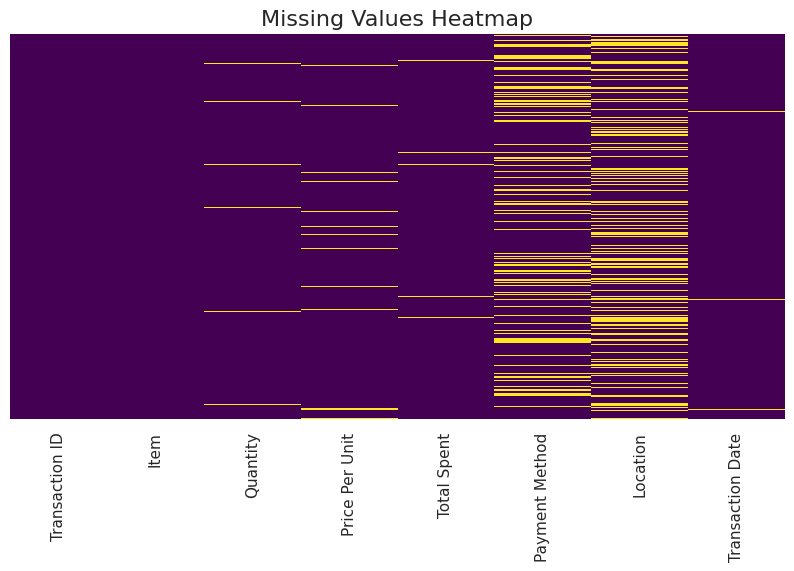

In [12]:
# check for Item missing values

plot_missing_values(df)

In [13]:
# 3. Quantity - numerical but stored as object , need cleaning
# First convert to string, than handle missing values
df['Quantity'] = df['Quantity'].astype(str)
df['Quantity'] = df['Quantity'].replace('nan', np.nan)
df['Quantity'] = df['Quantity'].replace('', np.nan)

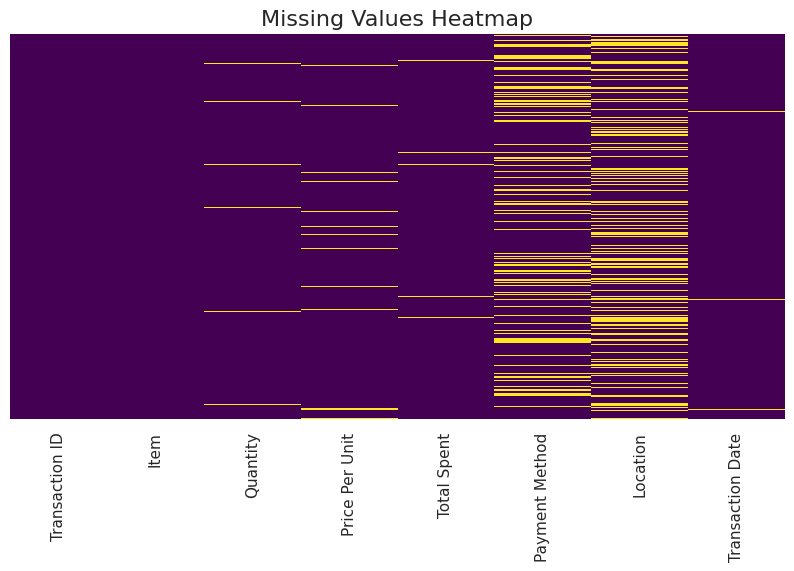

In [14]:
plot_missing_values(df)

In [15]:
# 4. Price Per Unit - similar to Quantity
df['Price Per Unit'] = df['Price Per Unit'].astype(str)
df['Price Per Unit'] = df['Price Per Unit'].replace('nan', np.nan)
df['Price Per Unit'] = df['Price Per Unit'].replace('', np.nan)

In [16]:
# 5. Total Spent - Similar to Quantity
df['Total Spent'] = df['Total Spent'].astype(str)
df['Total Spent'] = df['Total Spent'].replace('nan', np.nan)
df['Total Spent'] = df['Total Spent'].replace('', np.nan)

In [17]:
# 6. Payment Method - categorical
# Fill with 'Unknown' for missing payment methods 
df['Payment Method'] = df['Payment Method'].fillna('Unknown')


In [18]:
# 7. Location - categorical
# Fill with 'Unknown' for missing locations
df['Location'] = df['Location'].fillna('Unknown')

In [19]:
# 8. Transaction Date - datetime
# First convert to string, than handle missing values
df['Transaction Date'] = df['Transaction Date'].astype(str)
df['Transaction Date'] = df['Transaction Date'].replace('nan', np.nan)
df['Transaction Date'] = df['Transaction Date'].replace('', np.nan)

In [20]:
# Verify missing values after initial handling
print("Missing Values after initial handling:")
display(df.isnull().sum())

Missing Values after initial handling:


Transaction ID        0
Item                  0
Quantity            138
Price Per Unit      179
Total Spent         173
Payment Method        0
Location              0
Transaction Date    159
dtype: int64

# Data Cleaning and Type Conversion

In [21]:

from datetime import datetime
import warnings

# Suppress numeric comparison warnings
warnings.filterwarnings("ignore", message="invalid value encountered in greater")

def clean_dataframe(df):
    # Clean and convert numeric columns
    def clean_numeric_column(column):
        # Convert to string and clean
        column = column.astype(str).str.replace(r'[^\d.]', '', regex=True)
        return pd.to_numeric(column, errors='coerce')
    
    numeric_cols = ['Quantity', 'Price Per Unit', 'Total Spent']
    for col in numeric_cols:
        df[col] = clean_numeric_column(df[col])
    
    # Verify and reconcile numeric columns
    calculated_total = df['Quantity'] * df['Price Per Unit']
    discrepancies = np.abs(calculated_total - df['Total Spent']) > 0.01
    print(f"Number of total spent discrepancies: {discrepancies.sum()}")
    
    # Fill missing values using relationships between columns
    mask = df['Total Spent'].isna() & df['Quantity'].notna() & df['Price Per Unit'].notna()
    df.loc[mask, 'Total Spent'] = df.loc[mask, 'Quantity'] * df.loc[mask, 'Price Per Unit']
    
    mask = df['Quantity'].isna() & df['Total Spent'].notna() & df['Price Per Unit'].notna()
    df.loc[mask, 'Quantity'] = df.loc[mask, 'Total Spent'] / df.loc[mask, 'Price Per Unit']
    
    mask = df['Price Per Unit'].isna() & df['Total Spent'].notna() & df['Quantity'].notna()
    df.loc[mask, 'Price Per Unit'] = df.loc[mask, 'Total Spent'] / df.loc[mask, 'Quantity']
    
    # Clean and convert Transaction Date
    def clean_date(date_str):
        if pd.isna(date_str):
            return np.nan
        try:
            date_str = str(date_str).strip()
            for fmt in ('%Y-%m-%d', '%m/%d/%Y', '%d-%m-%Y', '%Y/%m/%d', '%d/%m/%Y', '%Y.%m.%d'):
                try:
                    return datetime.strptime(date_str, fmt).date()
                except ValueError:
                    continue
            return np.nan
        except:
            return np.nan
    
    df['Transaction Date'] = df['Transaction Date'].apply(clean_date)
    df['Transaction Date'] = pd.to_datetime(df['Transaction Date'], errors='coerce')
    
    # Handle missing dates - use mode if available, otherwise use median or today
    if not df['Transaction Date'].mode().empty:
        most_frequent_date = df['Transaction Date'].mode()[0]
    else:
        most_frequent_date = df['Transaction Date'].median() or pd.to_datetime('today').normalize()
    df['Transaction Date'] = df['Transaction Date'].fillna(most_frequent_date)
    
    # Create date-related features
    date_features = {
        'Transaction_Day': df['Transaction Date'].dt.day,
        'Transaction_Month': df['Transaction Date'].dt.month,
        'Transaction_Year': df['Transaction Date'].dt.year,
        'Transaction_DayOfWeek': df['Transaction Date'].dt.dayofweek,
        'Transaction_DayName': df['Transaction Date'].dt.day_name(),
        'Is_Weekend': df['Transaction Date'].dt.dayofweek.isin([5, 6]).astype(int)
    }
    df = df.assign(**date_features)
    
    # Clean categorical columns
    df['Item'] = df['Item'].astype(str).str.strip().str.title()
    
    # Standardize payment methods
    payment_mapping = {
        r'(?i)credit': 'Credit Card',
        r'(?i)debit': 'Debit Card',
        r'(?i)cash': 'Cash',
        r'(?i)mobile': 'Mobile Payment',
        r'(?i)paypal': 'Digital Wallet',
        r'(?i)digital': 'Digital Wallet'
    }
    
    df['Payment Method'] = df['Payment Method'].astype(str).str.strip().str.title()
    for pattern, replacement in payment_mapping.items():
        df['Payment Method'] = df['Payment Method'].str.replace(pattern, replacement, regex=True)
    df['Payment Method'] = df['Payment Method'].replace('Nan', 'Unknown').fillna('Unknown')
    
    # Clean location
    df['Location'] = df['Location'].astype(str).str.strip().str.title()
    
    return df

# Usage:
# df = clean_dataframe(df)

# Outlier Detection and Handling

In [22]:
# 1. Handling NaN Values (unchanged)
nan_mask = df.isna() | df.isnull()
nan_counts = df.isna().sum()

# 2. Handling Error Values (fixed)
# Method 1: Case-insensitive replacement without 'case' parameter
error_patterns = ['error', '#n/a', '#value', '#ref', '#div/0', 'UNKNOWN']
for pattern in error_patterns:
    df = df.replace(to_replace=pattern, value=np.nan, regex=True)

# Method 2: Alternative approach using str.contains
error_mask = df.apply(lambda col: col.astype(str).str.lower().str.contains(
    '|'.join(error_patterns), regex=True))
df = df.mask(error_mask, np.nan)

# 3. Handling Unknown Values (unchanged)
unknown_terms = ['unknown', 'unk', 'n/a', 'not available', 'missing', 'UNKNOWN']
df = df.replace(to_replace=unknown_terms, value=np.nan)

# 4. Final Imputation
# Numerical columns
num_cols = df.select_dtypes(include=np.number).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Categorical columns
cat_cols = df.select_dtypes(include='object').columns
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])


In [23]:
print("Price Per Unit", df["Price Per Unit"].unique())
print("Quantity", df["Quantity"].unique())
print("Total Spent", df["Total Spent"].unique())

Price Per Unit ['2.0' '3.0' '1.0' '5.0' '4.0' '1.5']
Quantity ['2' '4' '5' '3' '1']
Total Spent ['4.0' '12.0' '6.0' '10.0' '20.0' '9.0' '16.0' '15.0' '25.0' '8.0' '5.0'
 '3.0' '2.0' '1.0' '7.5' '4.5' '1.5']



After Conversion:
Price Per Unit: float64
Quantity dtype: int64
Total Spent float64


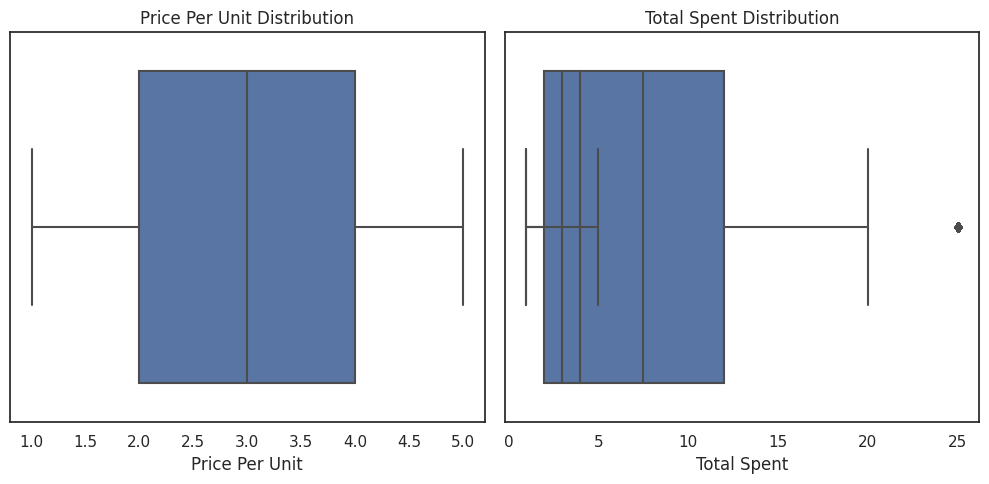

In [24]:
# Convert columns to numeric (will handle decimal point and integers)
df['Price Per Unit'] = pd.to_numeric(df['Price Per Unit'], errors = "coerce")
df['Quantity'] = pd.to_numeric(df['Quantity'], errors = "coerce")
df['Total Spent'] = pd.to_numeric(df['Total Spent'], errors = "coerce")

# Verify Conversion
print("\nAfter Conversion:")
print(f"Price Per Unit: {df['Price Per Unit'].dtype}")
print(f"Quantity dtype: {df['Quantity'].dtype}")
print(f"Total Spent {df['Total Spent'].dtype}")

# Now Create Visualization
plt.figure(figsize=(15, 5))

#1. Price Per Unit
plt.subplot(1, 3, 1)
sns.boxplot(x = df['Price Per Unit'].dropna())
plt.title("Price Per Unit Distribution")


# 2. Quantity
plt.subplot(1, 3, 2)
sns.boxplot(x = df['Quantity'].dropna())
plt.title("Quantity Distribution")

# 3. Total Spent
plt.subplot(1, 3, 2)
sns.boxplot(x = df['Total Spent'].dropna())
plt.title("Total Spent Distribution")

plt.tight_layout()
plt.show()


Outliers in Quantity: 0
Lower Bound: -1.00, Upper Bound: 7.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


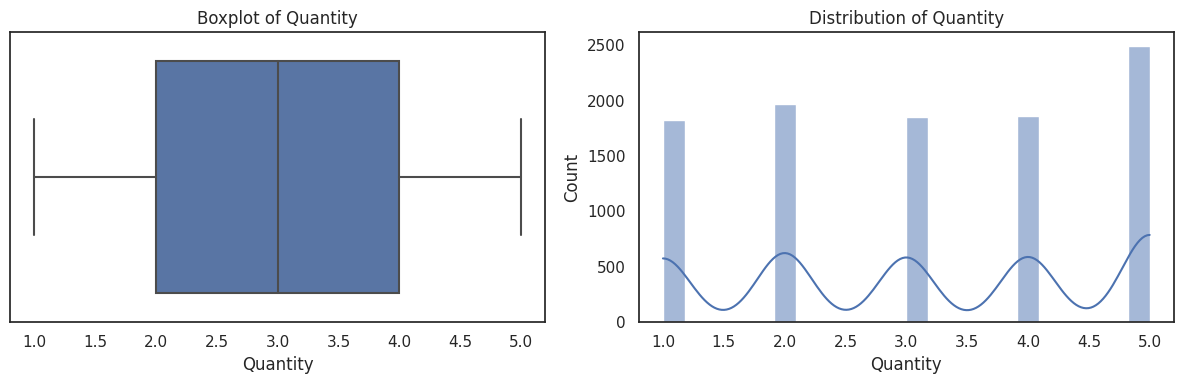


Outliers in Price Per Unit: 0
Lower Bound: -1.00, Upper Bound: 7.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


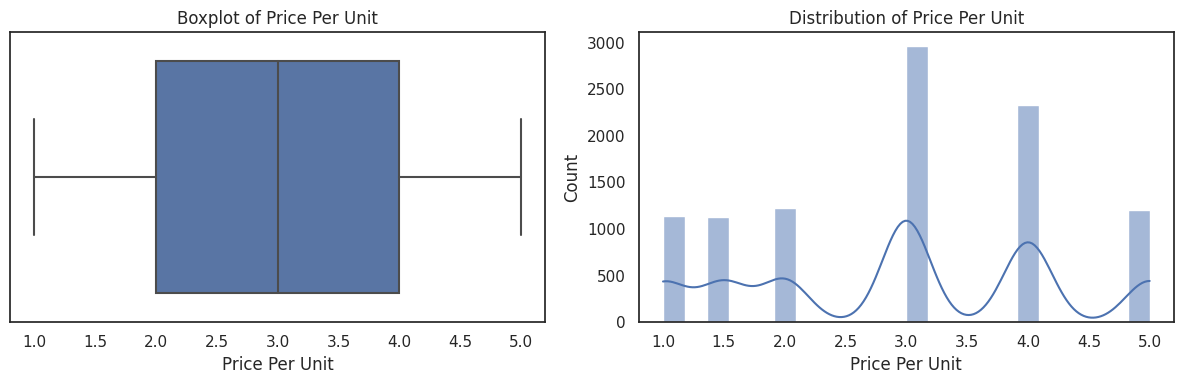


Outliers in Total Spent: 259
Lower Bound: -8.00, Upper Bound: 24.00
      Total Spent
10          25.00
51          25.00
52          25.00
96          25.00
100         25.00
...           ...
9791        25.00
9805        25.00
9879        25.00
9908        25.00
9971        25.00

[259 rows x 1 columns]


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


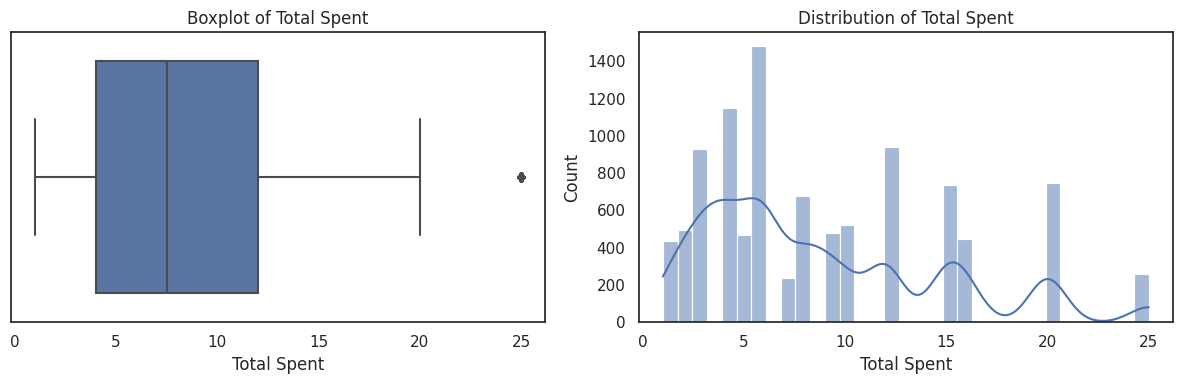

In [25]:
# Function to detect outliers using IQR method
def detect_outliers_iqr(data, column):
    # First ensure the column is numeric
    numeric_data = pd.to_numeric(data[column], errors='coerce')
    
    # Calculate quartiles only on non-null values
    Q1 = numeric_data.quantile(0.25)
    Q3 = numeric_data.quantile(0.75)
    IQR = Q3 - Q1
    
    # Calculate bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Find outliers (only considering rows with numeric values)
    outliers = data[(numeric_data < lower_bound) | (numeric_data > upper_bound)]
    return outliers, lower_bound, upper_bound

# Detect outliers in numeric columns
numeric_cols = ['Quantity', 'Price Per Unit', 'Total Spent']

for col in numeric_cols:
    outliers, lower_bound, upper_bound = detect_outliers_iqr(df, col)
    print(f"\nOutliers in {col}: {len(outliers)}")
    print(f"Lower Bound: {lower_bound:.2f}, Upper Bound: {upper_bound:.2f}")
    if len(outliers) > 0:
        print(outliers[[col]])

    # visualize distribution and outliers
    plt.figure(figsize=(12, 4))

    # First check if the column is numeric
    if pd.api.types.is_numeric_dtype(df[col]):
        plt.subplot(1, 2, 1)
        sns.boxplot(x=df[col])
        plt.title(f"Boxplot of {col}")
        
        plt.subplot(1, 2, 2)
        sns.histplot(df[col], kde=True)
        plt.title(f"Distribution of {col}")
        
        plt.tight_layout()
        plt.show()
    else:
        print(f"Skipping boxplot for {col} - column is not numeric")
        plt.subplot(1, 2, 1)
        sns.countplot(x=df[col])
        plt.title(f"Value counts of {col}")
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.show()



In [26]:
# Feature Engineering
df['Item'].unique()
df.head()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.00,4.00,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.00,12.00,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.00,6.00,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.00,10.00,Unknown,Unknown,2023-04-27
4,TXN_3160411,Coffee,2,2.00,4.00,Digital Wallet,In-store,2023-06-11


# Feature Engineering

In [27]:
# 1.Create a 'Item_Category' feature by grouping similar items
# But before this we have to handle unknown values form this column
# Handle Unknown values
# Check percentage of unknowns 
unknown_pct = (df['Item'] == 'Unknown').mean() * 100
print(f"Unknown items: {unknown_pct:.2f}%")

# Remove if percentage is small (<5%)
if unknown_pct < 5:
    df = df[df['Item'] != 'Unknown']
else:
    print("Consider imputation instead of removal")

# Define the category mapping for specific itms
item_categories = {
    'Coffee': ['Coffee'],
    'Tea': ['Tea'],
    'Cold Drinks': ['Smoothie', 'Juice'],
    'Food': ['Cake', 'Cookie', 'Salad', 'Sandwich']
}

# Create a reverse mapping for categorization
category_mapping = {}
for category, items in item_categories.items():
    for item in items:
        category_mapping[item] = category

# Function to categorize items 
def categorize_item(item):
    for key in category_mapping:
        if key in item:
            return category_mapping[key]
    return 'Other'
    
df['Item_Category'] = df['Item'].apply(categorize_item)    


# 3. Create a 'Discount' feature 
# Assuming discount might be when Total Spent is less than Quantity * Price Per Unit

df['Calculated_Total'] = df['Quantity'] * df['Price Per Unit']
df['Discount'] = (df['Calculated_Total'] - df['Total Spent']).clip(lower=0)
df['Discount_Perception'] = np.where(df['Calculated_Total'] > 0, (df['Discount'] / df['Calculated_Total']) * 100, 0)


Unknown items: 3.33%


In [28]:
df = df.rename(columns={'Discount_Perception': 'Discount_Percentage'})
df.columns

Index(['Transaction ID', 'Item', 'Quantity', 'Price Per Unit', 'Total Spent',
       'Payment Method', 'Location', 'Transaction Date', 'Item_Category',
       'Calculated_Total', 'Discount', 'Discount_Percentage'],
      dtype='object')

In [29]:
# df['Discount_Percentage'].head()

# unknown_pct = (df['Item'] == 'Unknown').mean() * 100
# print(f"Unknown items: {unknown_pct:.2f}%")

unknown_pct = (df['Location'] == 'Unknown').mean() * 100
print(f"Unknown Items: {unknown_pct:.2f}%")

Unknown Items: 39.74%


# Exploratory Data Analysis (EDA)

Numeric Features Summary:


,Quantity,Price Per Unit,Total Spent,Discount,Discount_Percentage
count,9667.00,9667.00,9667.00,9667.00,9667.00
mean,3.12,2.95,8.77,0.57,4.26
std,1.45,1.24,5.90,2.29,15.07
min,1.00,1.00,1.00,0.00,0.00
25%,2.00,2.00,4.00,0.00,0.00
50%,3.00,3.00,7.50,0.00,0.00
75%,4.00,4.00,12.00,0.00,0.00
max,5.00,5.00,25.00,20.00,93.33


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


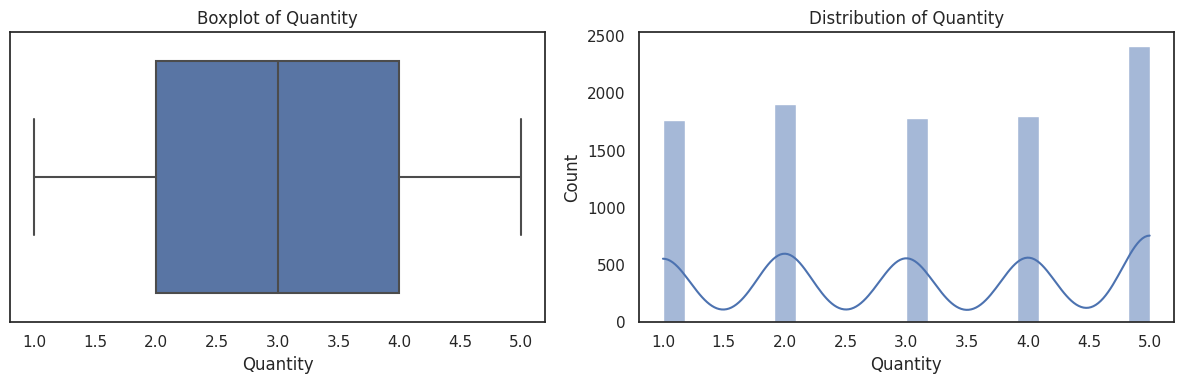

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


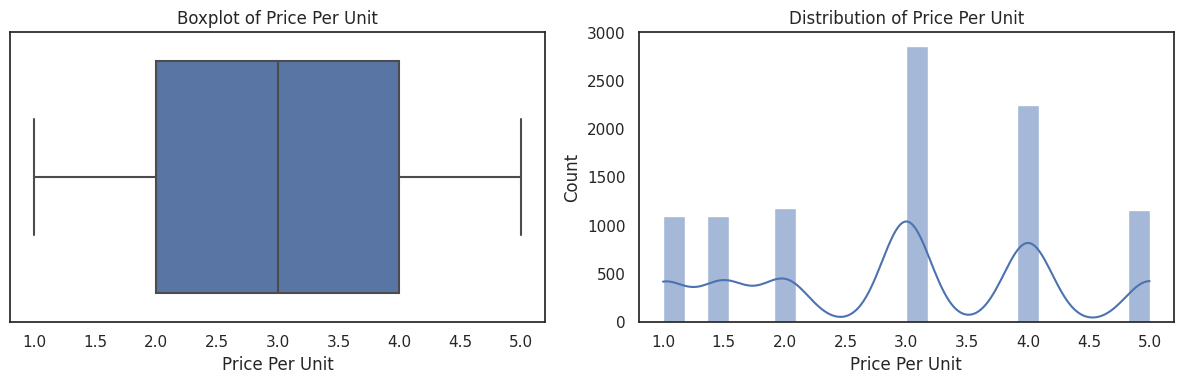

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


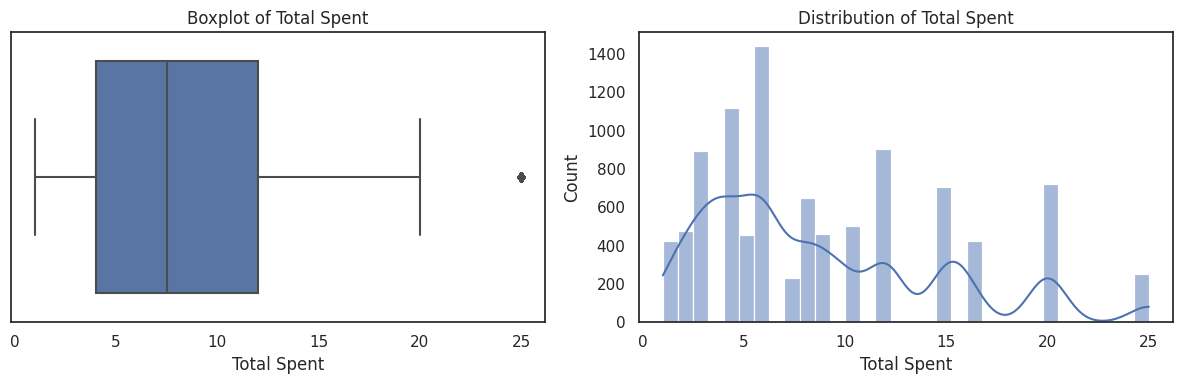

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


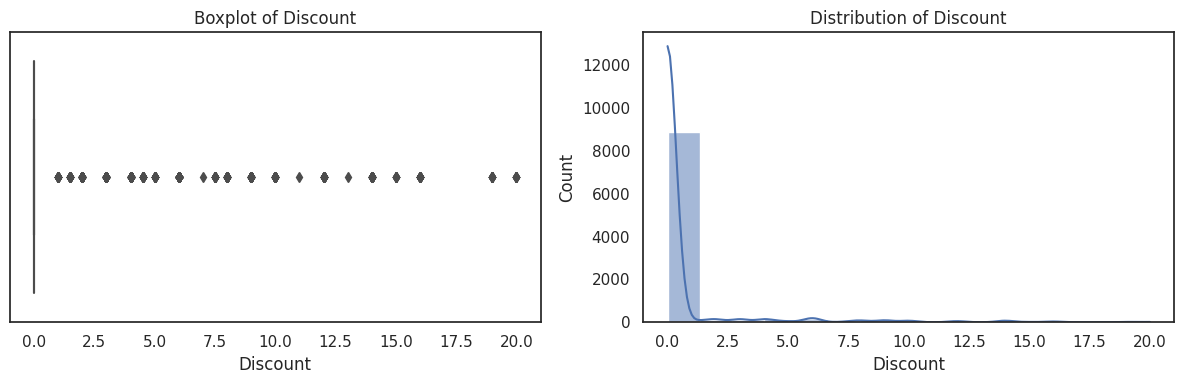

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


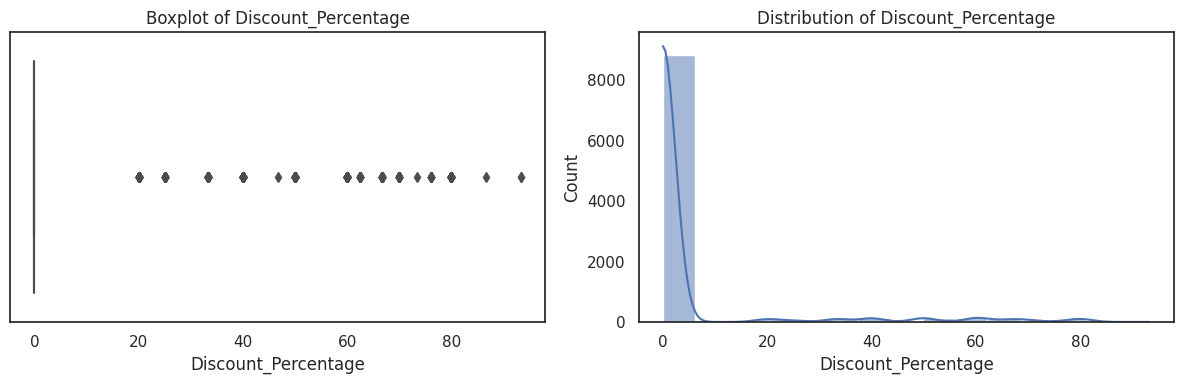

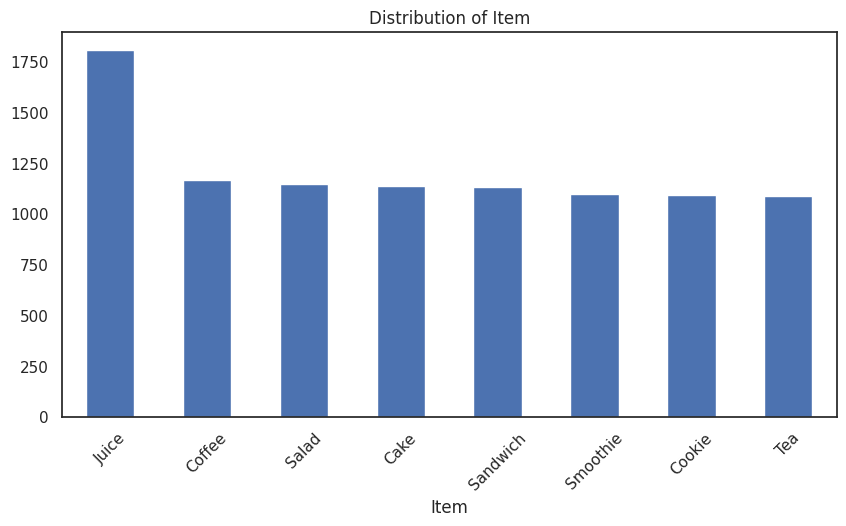

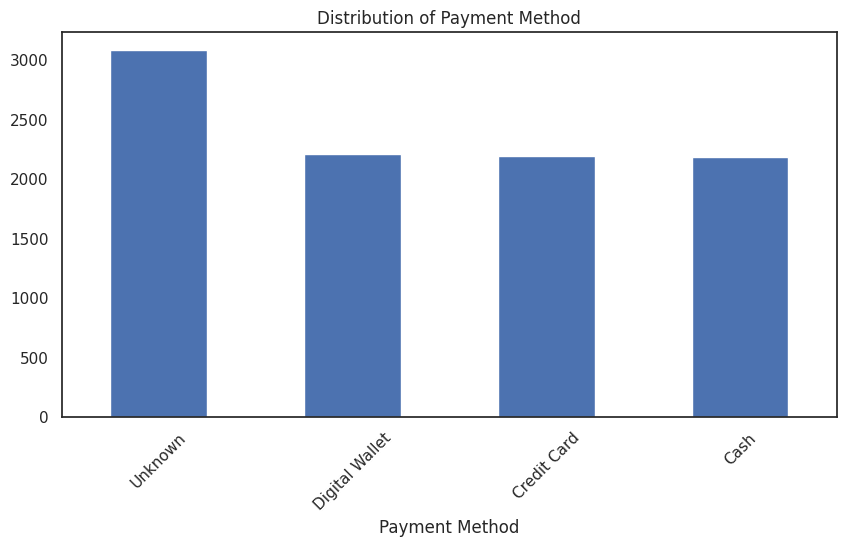

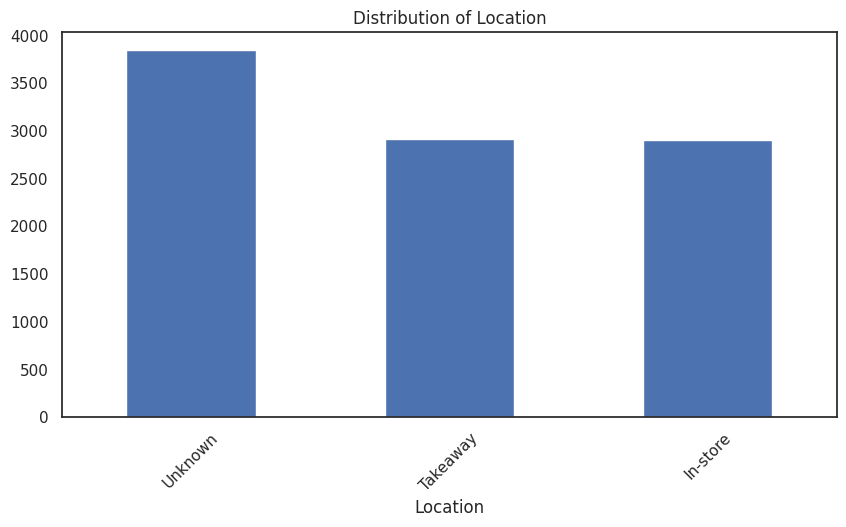

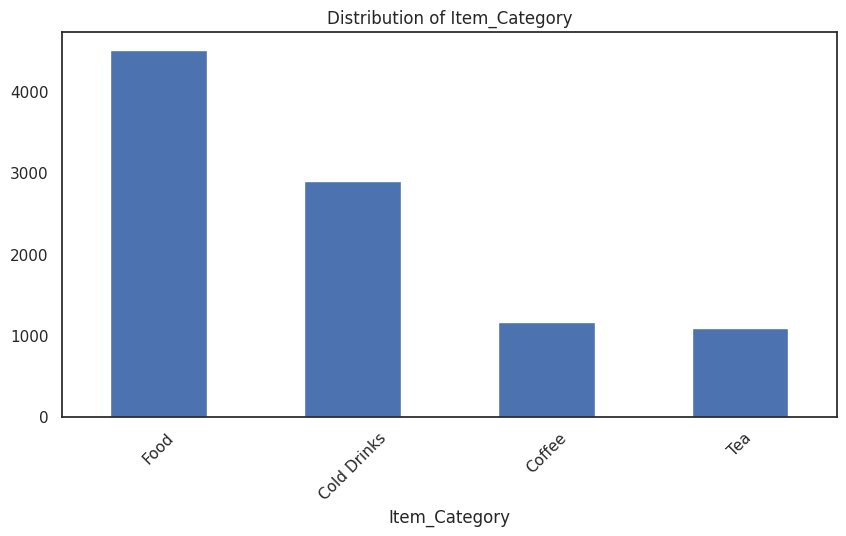

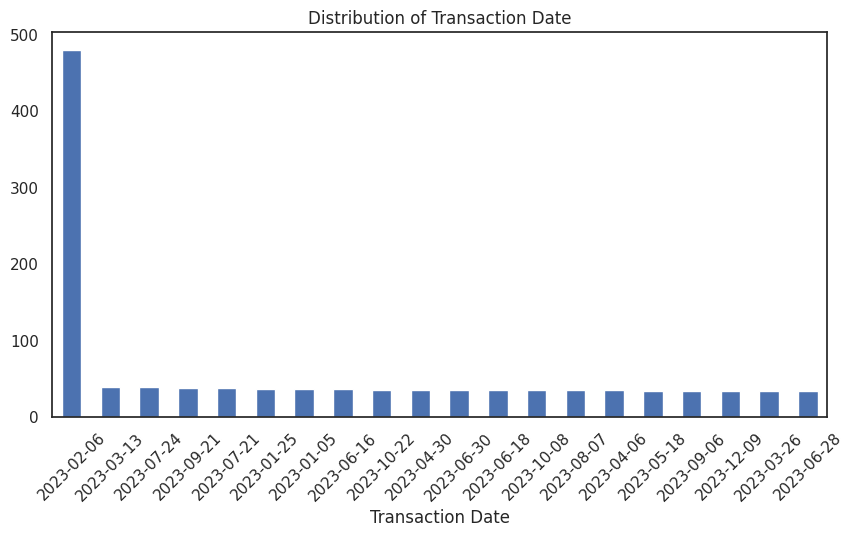

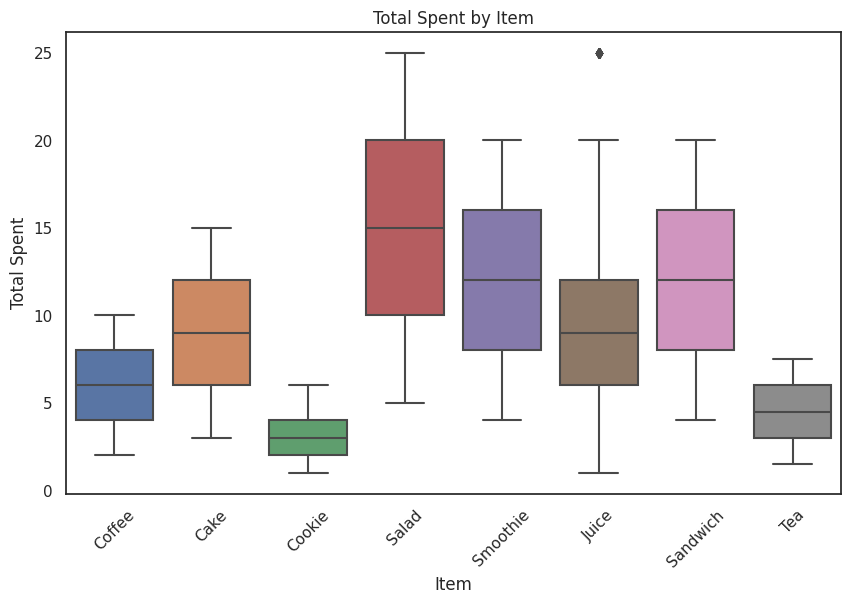

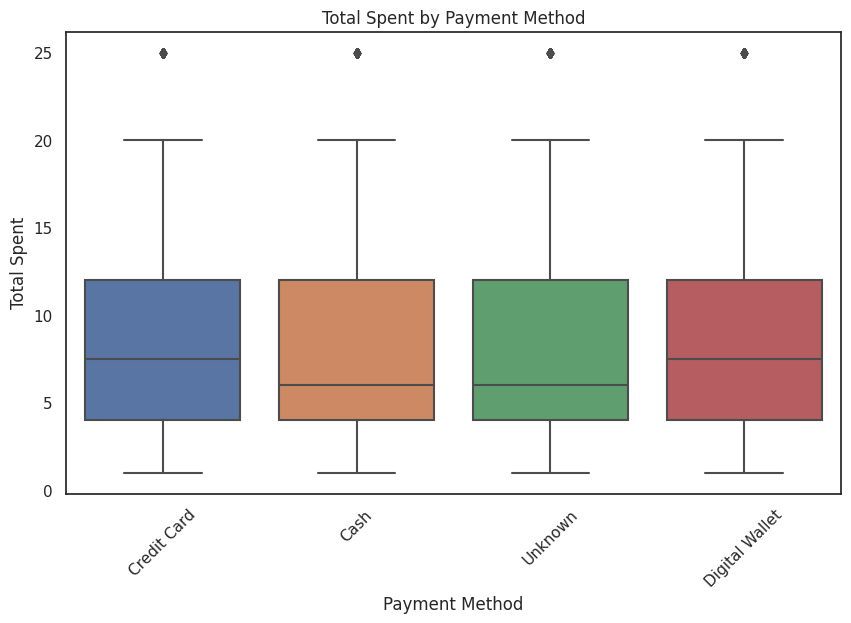

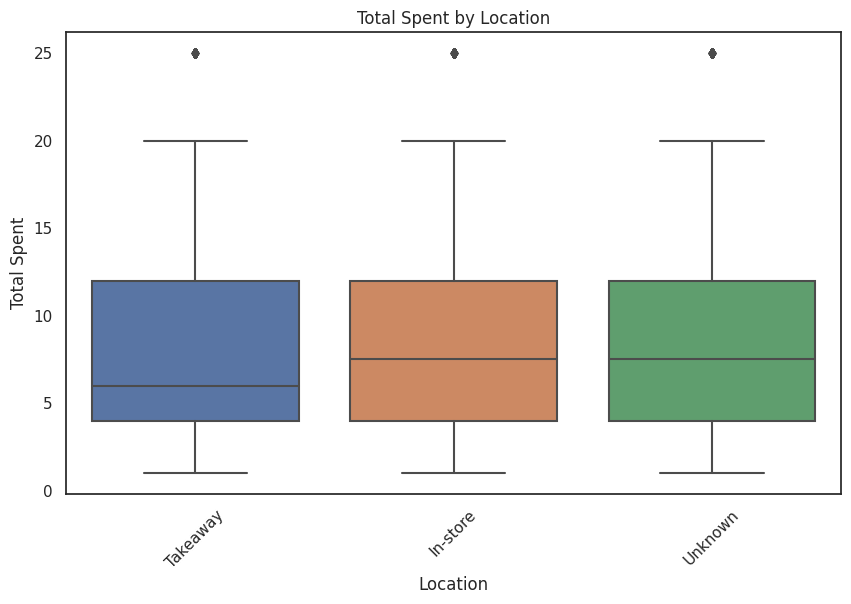

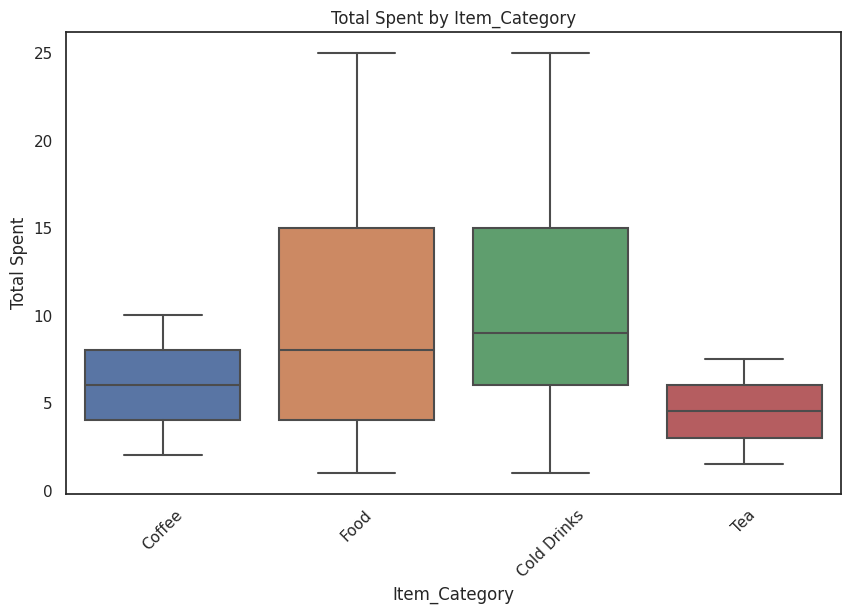

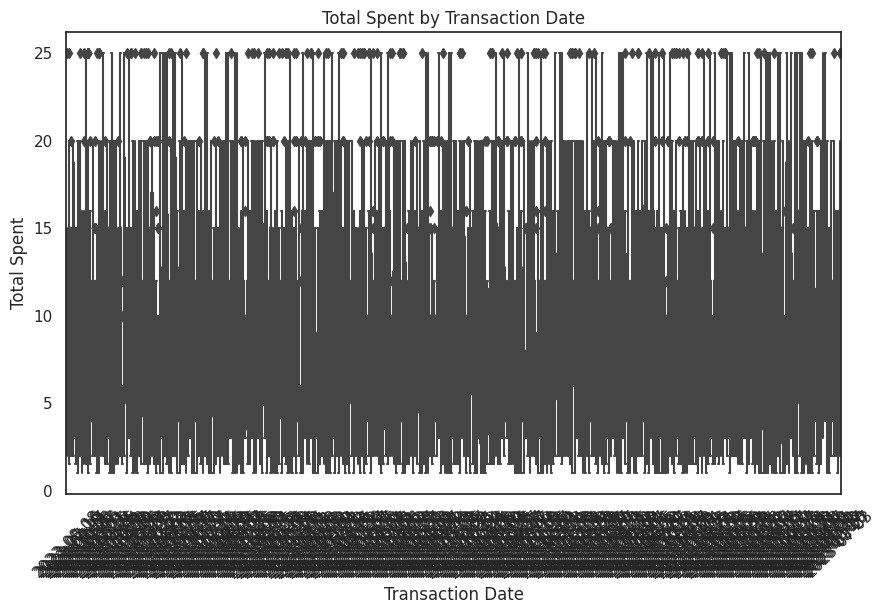

In [30]:
# Univariate Analysis
# Numerical Features
numeric_cols = ['Quantity', 'Price Per Unit', 'Total Spent', 'Discount', 'Discount_Percentage']
print("Numeric Features Summary:")
display(df[numeric_cols].describe())

# Visualize Numeric Features
for col in numeric_cols:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")

    plt.subplot(1, 2, 2)
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()


# Categorical Features
cat_cols = ['Item', 'Payment Method', 'Location', 'Item_Category', 'Size', 'Transaction Date']
for col in cat_cols:
    if col in df.columns:
        plt.figure(figsize=(10, 5))
        if df[col].nunique() > 10:
            df[col].value_counts().head(20).plot(kind='bar')
        else:
            df[col].value_counts().plot(kind='bar')
        plt.title(f"Distribution of {col}")
        plt.xticks(rotation=45)
        plt.show()

# Bivariate Analysis
# Relationship between categorical and numerical variables

for cat_col in ['Item', 'Payment Method', 'Location', 'Item_Category', 'Size', 'Transaction Date']:
    if cat_col in df.columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=cat_col, y = 'Total Spent', data=df)
        plt.title(f"Total Spent by {cat_col}")
        plt.xticks(rotation=45)
        plt.show()


In [31]:
numeric_cols = ['Transaction ID', 'Item', 'Quantity', 'Price Per Unit', 'Total Spent']
print(numeric_cols)

['Transaction ID', 'Item', 'Quantity', 'Price Per Unit', 'Total Spent']


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


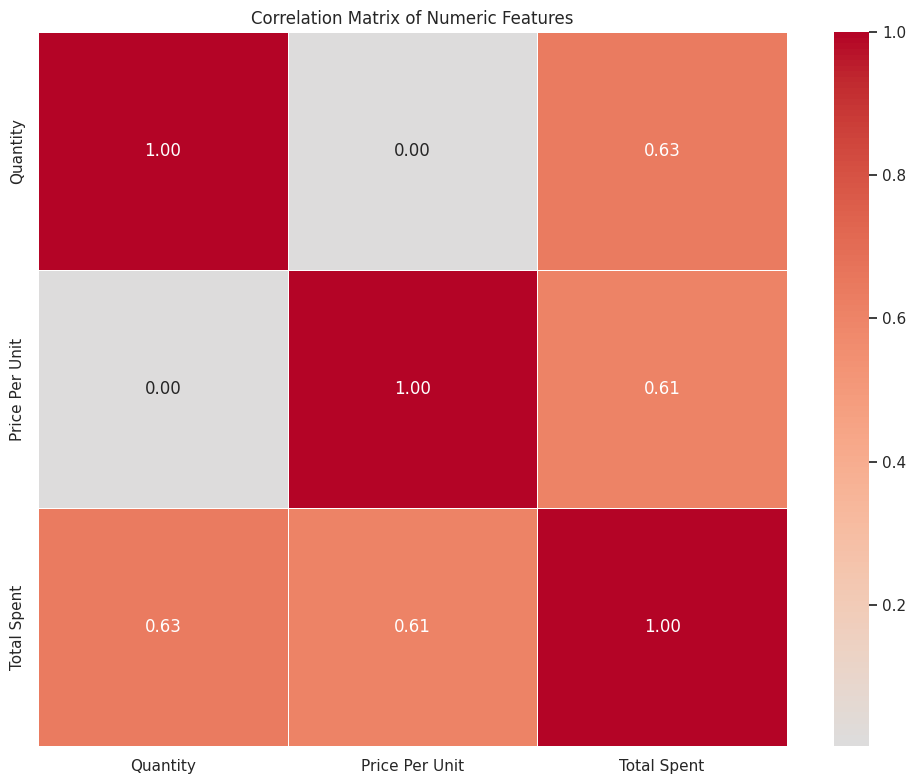

In [32]:
# Correlation between numerical variables
numeric_cols = ['Quantity', 'Price Per Unit', 'Total Spent']

# 2. Make sure the're numeric
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 3. Create the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', center=0, fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numeric Features")
plt.tight_layout()
plt.show()


In [33]:
df.columns

Index(['Transaction ID', 'Item', 'Quantity', 'Price Per Unit', 'Total Spent',
       'Payment Method', 'Location', 'Transaction Date', 'Item_Category',
       'Calculated_Total', 'Discount', 'Discount_Percentage'],
      dtype='object')

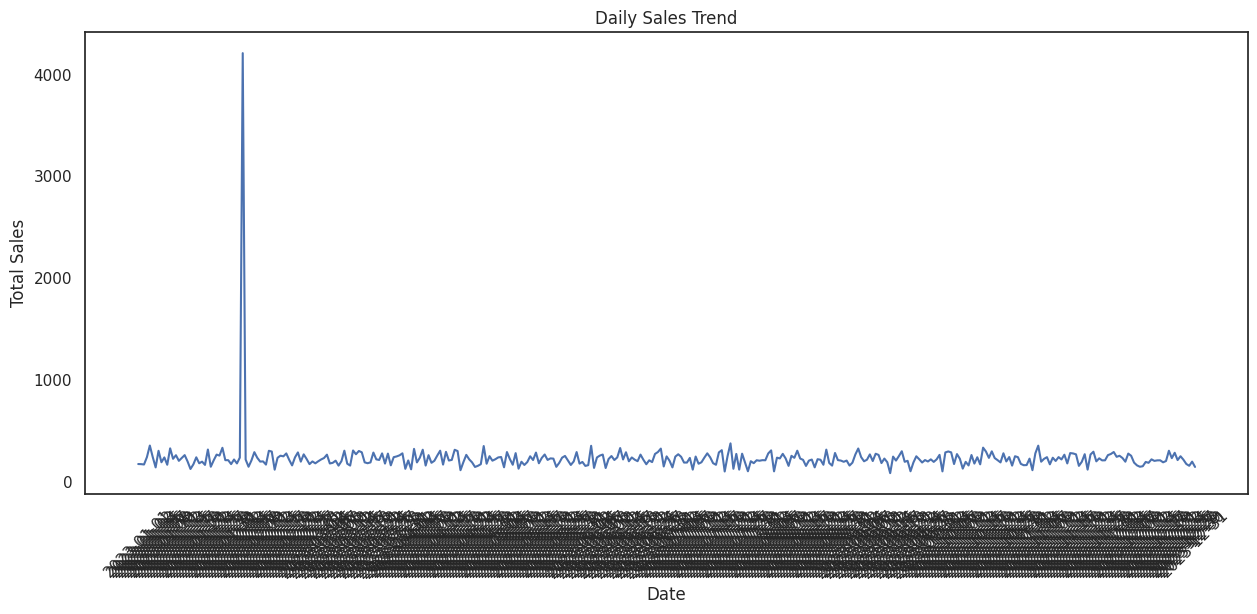

In [34]:
# 3. Time Series Analysis
if 'Transaction Date' in df.columns:
    # Daily Sales Trend
    daily_sales = df.groupby('Transaction Date')['Total Spent'].sum().reset_index()
    plt.figure(figsize=(15, 6))
    plt.plot(daily_sales['Transaction Date'], daily_sales['Total Spent'])
    plt.title('Daily Sales Trend')
    plt.xticks(rotation=45)
    plt.xlabel('Date')
    plt.ylabel('Total Sales')
    plt.show

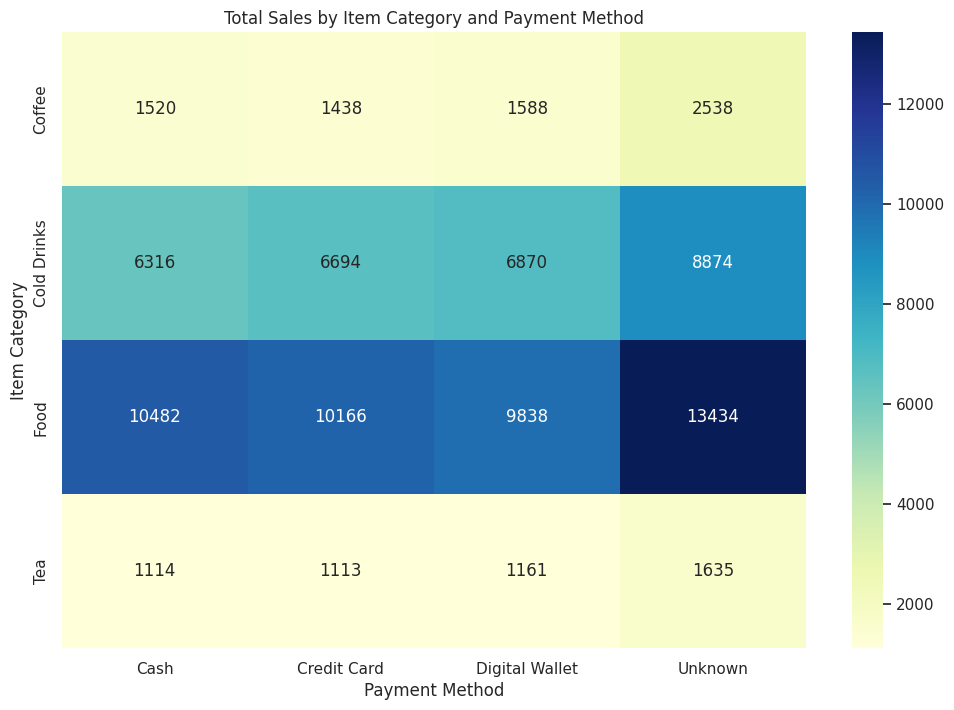

In [35]:
# Multivariate Analysis
# Payment Methos by item category
if 'Payment Method' in df.columns and 'Item_Category' in df.columns:
    cross_tab = pd.crosstab(df['Item_Category'], df['Payment Method'], values=df['Total Spent'], aggfunc='sum')
    plt.figure(figsize=(12, 8))
    sns.heatmap(cross_tab, annot=True, fmt='.0f', cmap='YlGnBu')
    plt.title("Total Sales by Item Category and Payment Method")
    plt.xlabel("Payment Method")
    plt.ylabel("Item Category")
    plt.show()

# Final Data Preprocessing For Modeling

In [36]:
# 1. Handling remaining missing values
# For numeric columns, impute with median
numeric_cols = ['Quantity', 'Price Per Unit', 'Total Spent', 'Discount', 'Discount_Percentage']
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
        print(f"Imputed {col} with median: {median_val:.2f}")


# 2. Feature Selection - Choose relevant features for modeling
# Remove columns that won't be useful for modeling or are redundant
cols_to_drop = ['Transaction ID', 'Calculated_Total', 'Transaction Date', 'Transaction_Day', 'Transaction_Time', "Hour_of_Day"]
df_model = df.drop(columns=[col for col in cols_to_drop if col in df.columns])


In [37]:
# Encoding Categorical Variables 
# For High cardinality categorical , use target encoding or frequency encoding
# For low cardinality , use one-hot encoding 

# List of Categorical columns
cat_cols = df_model.select_dtypes(include=['object', 'category']).columns.tolist()

# # Frequency encoding for high cardinality columns
high_cardinality = ['Item', 'Location']
for col in high_cardinality:
    if col in cat_cols:
        freq = df_model[col].value_counts(normalize=True)
        df_model[col+'_FreqEncoded'] = df_model[col].map(freq)
        df_model.drop(col, axis=1, inplace=True)
        cat_cols.remove(col)

# One-hot encoding for remaining categorical columns
df_model = pd.get_dummies(df_model, columns=cat_cols, drop_first=True)

# 4. Scale numeric features
# Separate features and target if needed (assuming Total Spent is target)

# For this example, let's assume we're predicting Total Spent
X = df_model.drop('Total Spent', axis = 1)
y = df_model['Total Spent']

# Scale numeric features
scaler = StandardScaler()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# 5. Final check befor modeling
print("\nFinal dataset shape:", X.shape)
print("\nFirst 5 rows of features:")
display(X.head())
print("\nFirst 5 rows of target:")
display(y.head())


Final dataset shape: (9667, 12)

First 5 rows of features:


,Quantity,Price Per Unit,Discount,Discount_Percentage,Item_FreqEncoded,Location_FreqEncoded,Payment Method_Credit Card,Payment Method_Digital Wallet,Payment Method_Unknown,Item_Category_Cold Drinks,Item_Category_Food,Item_Category_Tea
0,-0.77,-0.76,-0.25,-0.28,-0.32,-0.80,True,False,False,False,False,False
1,0.61,0.04,-0.25,-0.28,-0.42,-0.82,False,False,False,False,True,False
2,0.61,-1.57,-0.25,-0.28,-0.60,-0.82,True,False,False,False,True,False
3,-0.77,1.65,-0.25,-0.28,-0.39,1.23,False,False,True,False,True,False
4,-0.77,-0.76,-0.25,-0.28,-0.32,-0.82,False,True,False,False,False,False



First 5 rows of target:


0    4.00
1   12.00
2    6.00
3   10.00
4    4.00
Name: Total Spent, dtype: float64

# Saving the Cleaned Data

In [38]:
# # Save cleaned data for future use
# df.to_csv('cleaned_cafe_sales.csv', index=False)

# # Save preprocessed data for modeling
# pd.concat([X, y], axis=1).to_csv('preprocessed_cafe_sales.csv', index=False)

# Conclusion of Cleaning and EDA of Data

In [39]:
# This comprehensive guide covers all the essential steps in data cleaning, exploratory data analysis, feature engineering, and preprocessing:

# Initial Data Inspection: Understanding the structure and quality of your data

# Handling Missing Values: Identifying and addressing missing data appropriately

# Data Cleaning: Standardizing formats, correcting errors, and handling inconsistencies

# Outlier Detection: Identifying and managing extreme values

# Feature Engineering: Creating new meaningful features from existing data

# Exploratory Data Analysis: Understanding distributions, relationships, and patterns

# Preprocessing for Modeling: Encoding, scaling, and preparing data for machine learning

# Advanced Techniques: Optional methods for further refinement

# Saving Results: Preserving your cleaned data for future use

# Model Training, Evaluation, and Testing for Cafe Sales Prediction

In [40]:
# Separate features and target
X = df.drop('Total Spent', axis = 1)
y = df['Total Spent']

# Split data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape:{X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape:(7733, 11)
Test set shape: (1934, 11)


# Train and Evalueate Multiple Models


Numeric columns: ['Quantity', 'Price Per Unit', 'Calculated_Total', 'Discount', 'Discount_Percentage']
Categorical columns: ['Transaction ID', 'Item', 'Payment Method', 'Location', 'Transaction Date', 'Item_Category']

Training Linear Regression...

Evaluation Metrics for Linear Regression:
Mean Absolute Error (MAE): 0.30
Mean Squared Error (MSE): 0.54
Root Mean Squared Error (RMSE): 0.74
R-squared (R²): 0.9842


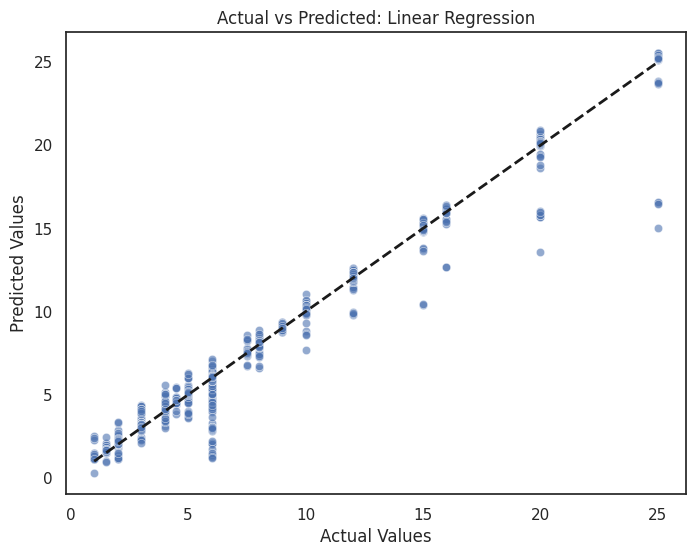


Training Ridge Regression...

Evaluation Metrics for Ridge Regression:
Mean Absolute Error (MAE): 0.29
Mean Squared Error (MSE): 0.54
Root Mean Squared Error (RMSE): 0.73
R-squared (R²): 0.9843


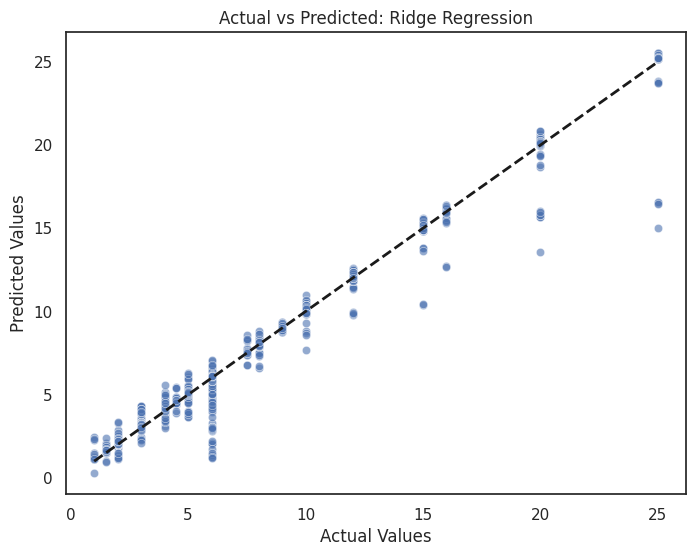


Training Lasso Regression...

Evaluation Metrics for Lasso Regression:
Mean Absolute Error (MAE): 1.35
Mean Squared Error (MSE): 3.38
Root Mean Squared Error (RMSE): 1.84
R-squared (R²): 0.9015


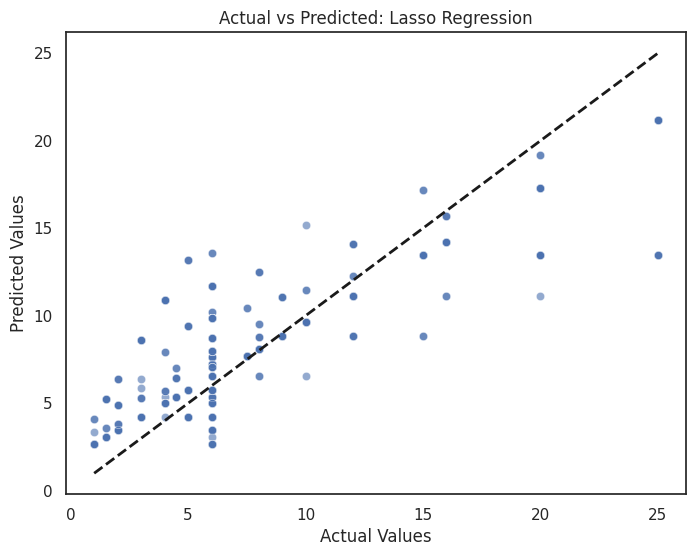


Training Random Forest...

Evaluation Metrics for Random Forest:
Mean Absolute Error (MAE): 0.09
Mean Squared Error (MSE): 0.41
Root Mean Squared Error (RMSE): 0.64
R-squared (R²): 0.9880


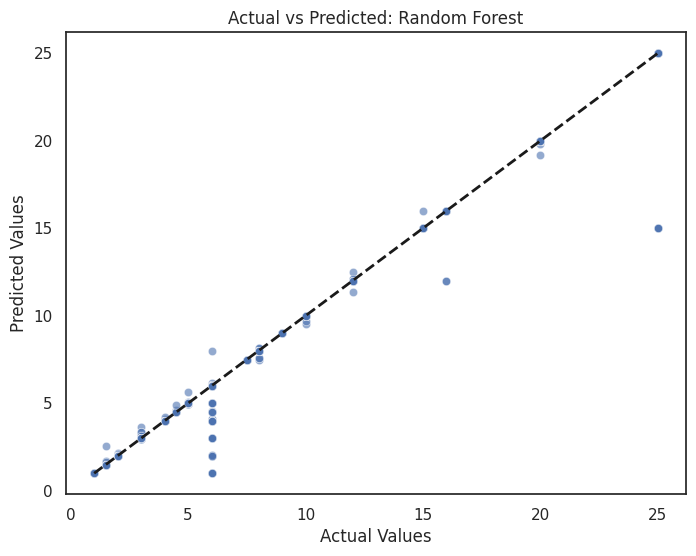


Training Gradient Boosting...

Evaluation Metrics for Gradient Boosting:
Mean Absolute Error (MAE): 0.23
Mean Squared Error (MSE): 0.38
Root Mean Squared Error (RMSE): 0.61
R-squared (R²): 0.9890


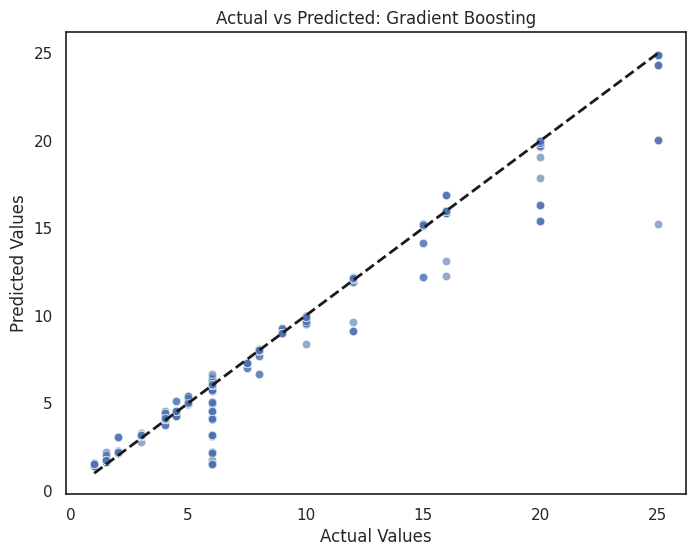


Training XGBoost...

Evaluation Metrics for XGBoost:
Mean Absolute Error (MAE): 0.13
Mean Squared Error (MSE): 0.26
Root Mean Squared Error (RMSE): 0.51
R-squared (R²): 0.9926


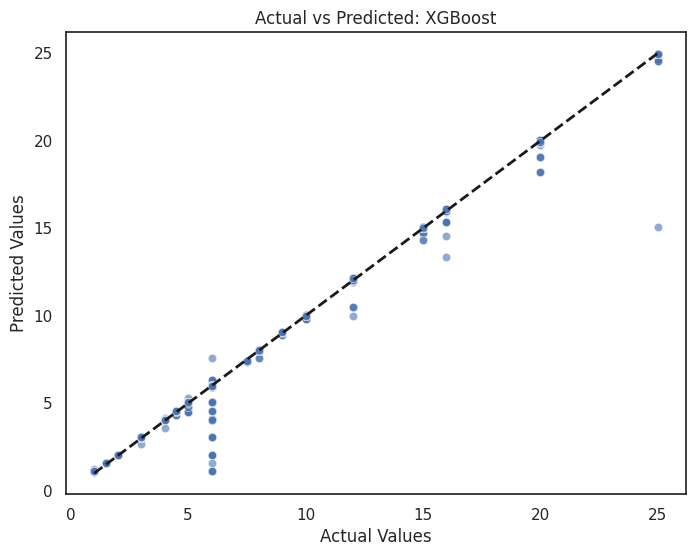


Training Support Vector Regression...

Evaluation Metrics for Support Vector Regression:
Mean Absolute Error (MAE): 0.20
Mean Squared Error (MSE): 0.37
Root Mean Squared Error (RMSE): 0.61
R-squared (R²): 0.9891


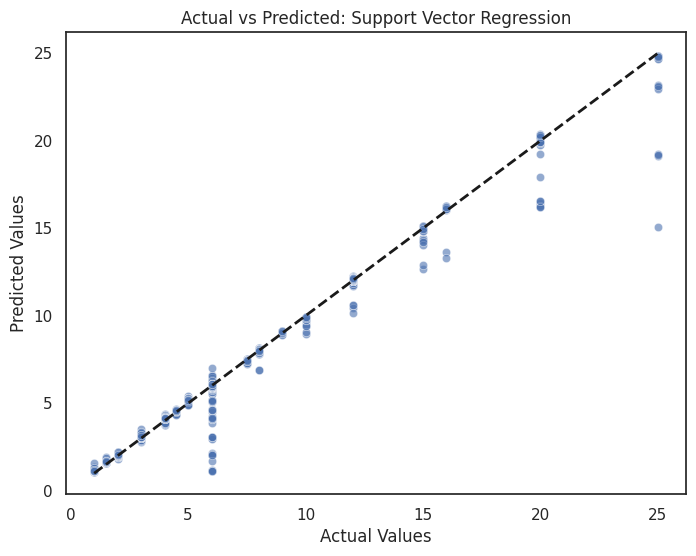


Training K-Neighbors Regressor...

Evaluation Metrics for K-Neighbors Regressor:
Mean Absolute Error (MAE): 0.26
Mean Squared Error (MSE): 0.53
Root Mean Squared Error (RMSE): 0.73
R-squared (R²): 0.9846


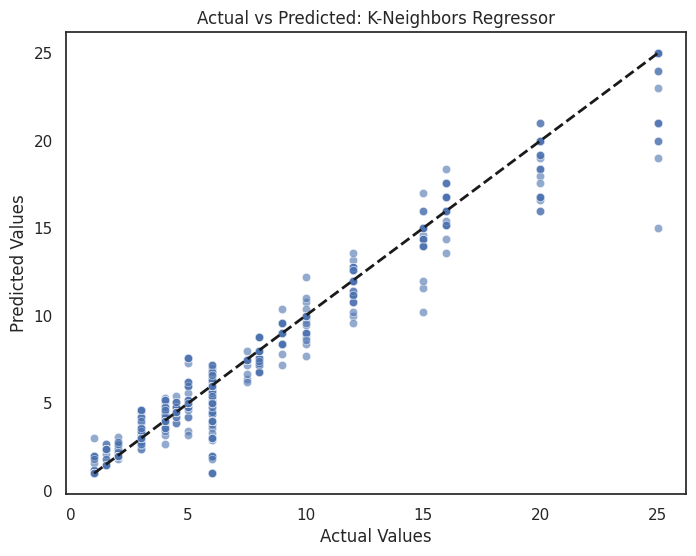


Model Comparison:
                           MAE  MSE  RMSE   R2
XGBoost                   0.13 0.26  0.51 0.99
Support Vector Regression 0.20 0.37  0.61 0.99
Gradient Boosting         0.23 0.38  0.61 0.99
Random Forest             0.09 0.41  0.64 0.99
K-Neighbors Regressor     0.26 0.53  0.73 0.98
Ridge Regression          0.29 0.54  0.73 0.98
Linear Regression         0.30 0.54  0.74 0.98
Lasso Regression          1.35 3.38  1.84 0.90


In [41]:
# Evaluation function
def evaluate_model(y_true, y_pred, model_name=""):
    """Calculate and print regression metrics"""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\nEvaluation Metrics for {model_name}:")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R-squared (R²): {r2:.4f}")
    
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}

# Plotting function
def plot_actual_vs_predicted(y_true, y_pred, title=""):
    """Visualize actual vs predicted values"""
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Actual vs Predicted: {title}")
    plt.show()


# 2. Identify column types
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print("\nNumeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

# 3. Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# 4. Apply preprocessing and split data
X_processed = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)

# 5. Define and train models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'Support Vector Regression': SVR(),
    'K-Neighbors Regressor': KNeighborsRegressor()
}

results = {}

for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training {name}...")
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Evaluate and plot
    results[name] = evaluate_model(y_test, y_pred, name)
    plot_actual_vs_predicted(y_test, y_pred, name)

# 6. Compare results
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df.sort_values('R2', ascending=False))



# Extract XGBoost from Trained Models 


Numeric columns: ['Quantity', 'Price Per Unit', 'Calculated_Total', 'Discount', 'Discount_Percentage']
Categorical columns: ['Transaction ID', 'Item', 'Payment Method', 'Location', 'Transaction Date', 'Item_Category']

Training XGBoost model...

XGBoost Model Evaluation:
MAE: 0.1532
MSE: 0.2610
RMSE: 0.5109
R2: 0.9924


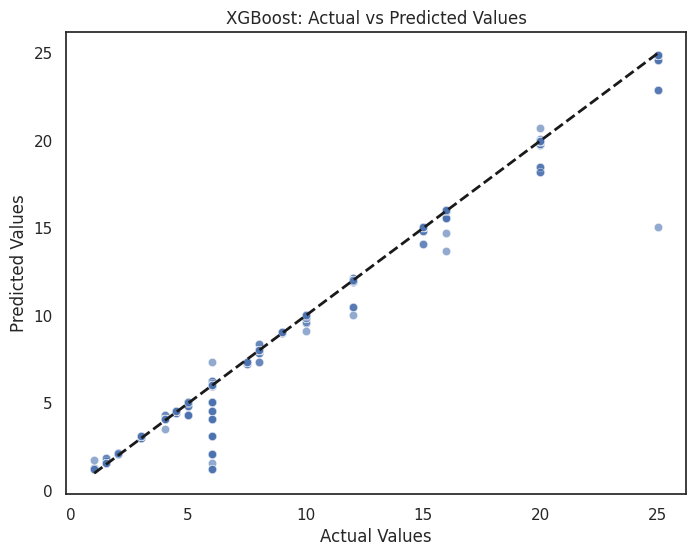


Model saved as xgboost_cafe_sales_model.pkl


In [42]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
import joblib

# 1. Load and prepare data (assuming X and y are already defined)
# If not, load your data first:
# df = pd.read_csv('your_data.csv')
# X = df.drop('Total Spent', axis=1)
# y = df['Total Spent']

# 2. Identify column types
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print("\nNumeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

# 3. Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# 4. Create full pipeline with XGBoost
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        random_state=42,
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.9
    ))
])

# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 6. Train the model
print("\nTraining XGBoost model...")
xgb_pipeline.fit(X_train, y_train)

# 7. Evaluate the model
y_pred = xgb_pipeline.predict(X_test)

print("\nXGBoost Model Evaluation:")
metrics = {
    'MAE': mean_absolute_error(y_test, y_pred),
    'MSE': mean_squared_error(y_test, y_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
    'R2': r2_score(y_test, y_pred)
}

for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# 8. Plot actual vs predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("XGBoost: Actual vs Predicted Values")
plt.show()

# 9. Save the model pipeline
model_filename = 'xgboost_cafe_sales_model.pkl'
joblib.dump(xgb_pipeline, model_filename)
print(f"\nModel saved as {model_filename}")

# 10. Example of loading and using the model
# loaded_model = joblib.load(model_filename)
# new_prediction = loaded_model.predict(new_data)

In [43]:
from IPython.display import FileLink

# Create a download link
FileLink('xgboost_cafe_sales_model.pkl')

/kaggle/working/xgboost_cafe_sales_model.pkl